## Ocean Biogeochemical Dynamics Lab, Spring 2021
Doing simple seasonal decomposition of drivers of DIC and TA with SOCCOM floats by Nancy Williams

This assumes you have already become familiar with `OBD_SOCCOM_L3.ipynb` and `OBD_SOCCOM_CO2SYS.ipynb` notebooks.

SOCCOM website: https://soccom.princeton.edu/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns # this will change the look of pandas plots, too
import cartopy.crs as ccrs
import cartopy.feature
import seawater
import xarray as xr
from PyCO2SYS.api import CO2SYS_wrap as co2sys
import os
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15,9)
plt.rcParams['font.size'] = 18
#plt.rcParams['lines.linewidth'] = 3
# this forces matplotlib to print figures out here when you make plots
from IPython.display import Image

In [2]:
# Define the directory where you want the figures to be saved
output_dir = 'generated/'

# Importing the dataset
We want to use Pandas' built-in read_csv function to import a single float data file into a pandas data frame called `flt`. Float 9096 is a good example float for this exercise, but you can pick any float from the snapshot. To pick another float you can go to the SOCCOM web page sensor status table http://soccom.ucsd.edu/floats/SOCCOM_sensor_stats.html and choose a float with lots of good data (i.e., more in the "#g" column than the "#b" columns for variables you're interested in analyzing. You can sort the columns on that webpage by clicking on the column header by which you wish to sort.

In [3]:
# Pick a float
floatnum='9096' 
floatpath='SOCCOM_LoResQC_LIAR_22Dec2020_odvtxt/' # This is the folder where all the float data live
floatsuffix='SOOCNQC.TXT' # all of the Southern Ocean floats have the same suffix

In [4]:
# Change // comment symbols to #
# input file
fin = open(floatpath+floatnum+floatsuffix,'rt',encoding='UTF-8')

# output file to which we will write the result
fout = open('fltrem.txt','wt')

# this is a for loop
# for each line in the input file
for line in fin:
    # red and replace the string and write to the output file
    fout.write(line.replace('//','#'))
# close the files
fin.close()
fout.close()

In [11]:
flt=pd.read_csv('fltrem.txt',delimiter='\t',comment='#',na_values=-1E10)
flt['date']=pd.to_datetime(flt['mon/day/yr']+' '+ flt['hh:mm'])

In [12]:
flt

,Cruise,Station,Type,mon/day/yr,hh:mm,Lon [°E],Lat [°N],QF,Pressure[dbar],QF.1,...,QF.14,pH25C[Total],QF.15,TALK_LIAR[µmol/kg],QF.16,DIC_LIAR[µmol/kg],QF.17,pCO2_LIAR[µatm],QF.18,date
0,5904469,1,C,12/11/2014,12:17,0.015,-53.513,0,1599.22,0.0,...,0.0,7.5904,0.0,2357.0,0.0,2262.0,0.0,490.4,0.0,2014-12-11 12:17:00
1,5904469,1,C,12/11/2014,12:17,0.015,-53.513,0,1498.92,0.0,...,0.0,7.5901,0.0,2357.0,0.0,2263.0,0.0,492.6,0.0,2014-12-11 12:17:00
2,5904469,1,C,12/11/2014,12:17,0.015,-53.513,0,1398.57,0.0,...,0.0,7.5921,0.0,2357.0,0.0,2261.0,0.0,492.2,0.0,2014-12-11 12:17:00
3,5904469,1,C,12/11/2014,12:17,0.015,-53.513,0,1299.41,0.0,...,0.0,7.5918,0.0,2356.0,0.0,2261.0,0.0,495.1,0.0,2014-12-11 12:17:00
4,5904469,1,C,12/11/2014,12:17,0.015,-53.513,0,1199.77,0.0,...,0.0,7.5920,0.0,2356.0,0.0,2260.0,0.0,497.4,0.0,2014-12-11 12:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10533,5904469,160,C,06/07/2019,18:59,25.771,-62.998,0,30.25,0.0,...,8.0,NaN,1.0,2307.0,0.0,NaN,1.0,NaN,1.0,2019-06-07 18:59:00
10534,5904469,160,C,06/07/2019,18:59,25.771,-62.998,0,22.20,0.0,...,8.0,NaN,1.0,2307.0,0.0,NaN,1.0,NaN,1.0,2019-06-07 18:59:00
10535,5904469,160,C,06/07/2019,18:59,25.771,-62.998,0,14.82,0.0,...,8.0,NaN,1.0,2308.0,0.0,NaN,1.0,NaN,1.0,2019-06-07 18:59:00
10536,5904469,160,C,06/07/2019,18:59,25.771,-62.998,0,7.65,0.0,...,8.0,NaN,1.0,2307.0,0.0,NaN,1.0,NaN,1.0,2019-06-07 18:59:00


In [13]:
# Loop through all Quality Flag columns and apply them to the preceeding columns
from re import search
for column in range(len(flt.columns)):
    name=flt.columns[column]
    if search('QF',name): # if the column is a QF column, apply it to the preceeding column, otherwise go on to next column
        var=flt.columns[column-1]
        flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)

# Mapping your data
It's always a good idea to map your data and make sure it is where you think it is. Here we will use cartopy (basemap is deprecated).

Since we're talking about the Southern Ocean and there are stark fronts, it's good to plot your data in relation to these fronts. The climatological locations of the fronts are available from Orsi et al. (1995) https://www.sciencedirect.com/science/article/pii/096706379500021W. Text files containing the locations of the fronts are located in the "fronts" folder.

>Orsi, A. H., Whitworth, T. I., & Nowlin, W. D. J. (1995). On the meridional extent and fronts of the Antarctic Circumpolar Current. Deep Sea Research Part I. https://doi.org/10.1016/0967-0637(95)00021-W

### Where is your float in relation to the fronts of the ACC?
The following code imports the longitudes and latitudes of the five fronts. There are some '%' values in the files which creates breaks in the fronts. If we did not keep these breaks, the fronts would plot across continents.

In [14]:
stf=pd.read_csv('fronts/stf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saf=pd.read_csv('fronts/saf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
pf=pd.read_csv('fronts/pf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saccf=pd.read_csv('fronts/saccf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
sbdy=pd.read_csv('fronts/sbdy.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])

The following is an example of a South Polar Stereographic map using Cartopy https://scitools.org.uk/cartopy/docs/latest/#. Polar stereographic maps are always a bit more complicated because you have to translate your coordinates to polar coordinates.

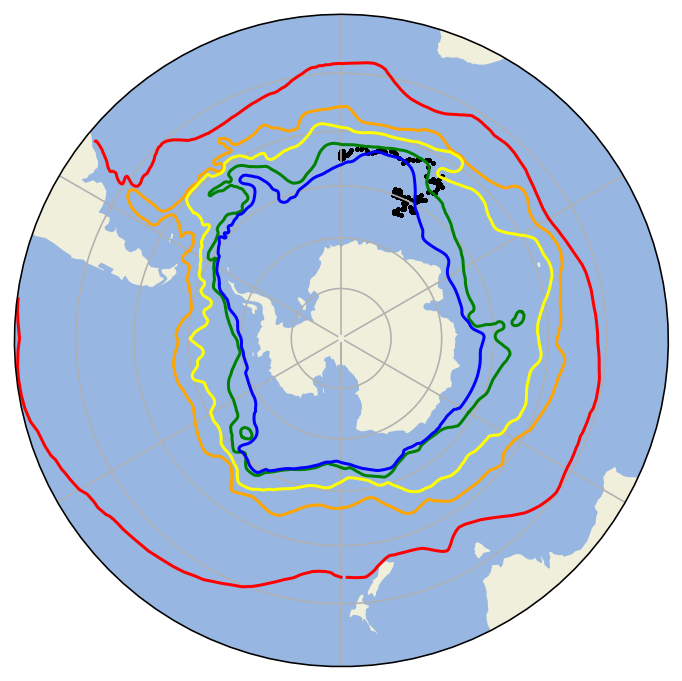

In [15]:
plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-30],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
plt.plot(stf['lon'],stf['lat'],color='Red',transform=ccrs.PlateCarree())
plt.plot(saf['lon'],saf['lat'],color='Orange',transform=ccrs.PlateCarree())
plt.plot(pf['lon'],pf['lat'],color='Yellow',transform=ccrs.PlateCarree())
plt.plot(saccf['lon'],saccf['lat'],color='Green',transform=ccrs.PlateCarree())
plt.plot(sbdy['lon'],sbdy['lat'],color='Blue',transform=ccrs.PlateCarree())

plt.scatter(flt['Lon [°E]'],flt['Lat [°N]'],color='Black',transform=ccrs.PlateCarree(), s=1)
plt.savefig(output_dir+'F'+floatnum+'map.png') 
plt.savefig(output_dir+'F'+floatnum+'map.jpg') # Changing the suffix will change the format
plt.show()


In [16]:
# Calculate MLD for each station
MLD=[]
for station in flt['Station'].unique():
    surfacedens=flt['Sigma_theta[kg/m^3]'].loc[(flt['Station']==station)].min()
    MLD.append([station,flt['date'].loc[(flt['Station']==station)&(flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
                flt['Depth[m]'].loc[(flt['Station']==station)&(flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
              flt['Lon [°E]'].loc[(flt['Station']==station)].mean(),
              flt['Lat [°N]'].loc[(flt['Station']==station)].mean()])

# Take a look at MLD. First column is the Station, second column is datenum, second column is the MLD
MLD = pd.DataFrame(data=MLD, columns=['Station', 'date', 'MLD','Lon [°E]','Lat [°N]'])

## Do some CO2SYS calculations using PyCO2SYS
This section uses PyCO2sys to do some carbonate system calculations using the float data. The float pH sensor measures pH with an uncertainty of about 0.01 (Williams et al., 2017; Johnson et al., 2017). We need a second variable in order to do CO2SYS calculations, and the easiest to estimate in this case is total alkalinity, or TA. The estimate for TA comes from an empirical algorithm called LIARv2. LIARv2 uses float-measured salinity, temperature, pressure, oxygen, and location along with existing nearby bottle measurements for alkalinity to estimate TA at the float's location with an uncertainty of about 6.5 umol/kg (Carter et al., 2018). 

>Williams, N. L., Juranek, L. W., Feely, R. A., Johnson, K. S., Sarmiento, J. L., Talley, L. D., et al. (2017). Calculating surface ocean pCO2 from biogeochemical Argo floats equipped with pH: An uncertainty analysis. Global Biogeochemical Cycles, 31(3), 591–604. https://doi.org/10.1002/2016GB005541

>Johnson, K. S., Plant, J. N., Coletti, L. J., Jannasch, H. W., Sakamoto, C. M., Riser, S. C., et al. (2017). Biogeochemical sensor performance in the SOCCOM profiling float array. Journal of Geophysical Research: Oceans, 122(8), 6416–6436. https://doi.org/10.1002/2017JC012838

>Carter, B. R., Feely, R. A., Williams, N. L., Dickson, A. G., Fong, M. B., & Takeshita, Y. (2018). Updated methods for global locally interpolated estimation of alkalinity, pH, and nitrate. Limnology and Oceanography: Methods, 16(2), 119–131. https://doi.org/10.1002/lom3.10232

If you use PyCO2SYS in your own research, please cite: 

>Humphreys, M. P., Gregor, L., Pierrot, D., van Heuven, S. M. A. C., Lewis, E. R., and Wallace, D. W. R. (2020). PyCO2SYS: marine carbonate system calculations in Python. Zenodo. doi:10.5281/zenodo.3744275.

As well as the original CO2SYS:

>van Heuven, S., Pierrot, D., Rae, J. W. B., Lewis, E., and Wallace, D. W. R. (2011). CO2SYS v 1.1, MATLAB program developed for CO2 system calculations. ORNL/CDIAC-105b, Carbon Dioxide Information Analysis Center, Oak Ridge National Laboratory, U.S. Department of Energy, Oak Ridge, TN, USA. doi:10.3334/CDIAC/otg.CO2SYS_MATLAB_v1.1.

More examples available at https://github.com/mvdh7/PyCO2SYS-examples

### First, let's do an example to make sure we understand the various inputs and outputs:
To do carbonate system calculations you need to have measured (or estimated) at least two of the measurable variables (DIC, TA, pCO2, pH).

Below are two ways to call co2sys which are reminiscent of how it is used in MATLAB. You only have to enter the two carbonate system variables, and if you enter nothing else co2sys will assume "standard" conditions of S=35, T=25, and a default set of constants. A list of all possible inputs is available here: https://pyco2sys.readthedocs.io/en/latest/co2sys/#inputs

In [10]:
# Do an example
# Call with defaults
df1 = co2sys(dic=2103, alk=2360)

# The above is equivalent to:
df1 = co2sys(
    dic=2103, alk=2360, pco2=None, fco2=None, pH=None,
    carb=None, bicarb=None, co2aq=None,
    temp_in=25, temp_out=25, pres_in=0, pres_out=0,
    sal=35, si=0, po4=0, nh3=0, h2s=0,
    K1K2_constants=4, KSO4_constants=1, KF_constant=1, pHscale_in=1,
    buffers_mode="auto", verbose=True)
# You can see from the output below that this block of code runs twice.

Convert data to pandas.DataFrame
Removing nans for efficiency
Computing CO2 parameters
Insert nans back into DataFrame
Convert data to pandas.DataFrame
Removing nans for efficiency
Computing CO2 parameters
Insert nans back into DataFrame


In [11]:
# look at the output
df1

,TAlk,TCO2,pHin,pCO2in,fCO2in,HCO3in,CO3in,CO2in,BAlkin,OHin,...,PAR1TYPE,PAR2TYPE,K1K2CONSTANTS,KSO4CONSTANTS,KSO4CONSTANT,KFCONSTANT,BORON,pHSCALEIN,buffers_mode,WhichR
0,2360.0,2103.0,7.960806,516.535671,514.888159,1900.218941,188.162415,14.618644,77.967076,5.500343,...,2,1,4,1,1,1,1,1,auto,1


The output is one long row with 132 columns of both input and output similar to the excel version or the MATLAB version. A list of all outputs is avaiable here: https://pyco2sys.readthedocs.io/en/latest/co2sys/#outputs

You can call a specific column with your result of interest. What is the saturation state of aragonite? Is this example above or below saturation (i.e., will aragonite shells tend to dissolve or be stable at these conditions?)

In [12]:
df1['OmegaARout']

0    2.985562
Name: OmegaARout, dtype: float64

Now, let's use co2sys to calculate aragonite saturation state (OmegaAr) from the float data. We need to provide more information than in the simple example above, because the float is measuring at a range of temperature, salinity, and pressure conditions. These are called "in situ" conditions. For a float, we are interested in what's happening in situ, so both our input and output conditions will be the in situ conditions and they will be the same.

>As a side note: you would do something different if you were measuring a water sample in the lab, and then you wish to back-calculate what your sample looked like at in situ conditions (i.e. wherever you sampled it from). In that case, your input conditions would be your lab conditions, and your output conditions would be the insitu conditions. 

In [13]:
df1 = co2sys(
    pH=flt['pHinsitu[Total]'], alk=flt['TALK_LIAR[µmol/kg]'],
    temp_in=flt['Temperature[°C]'], temp_out=flt['Temperature[°C]'], 
    pres_in=flt['Pressure[dbar]'], pres_out=flt['Pressure[dbar]'],
    sal=flt['Salinity[pss]'], si=0, po4=0, nh3=0, h2s=0,
    K1K2_constants=10, KSO4_constants=1, KF_constant=1, pHscale_in=1,
    buffers_mode="auto", verbose=True)

df1

Convert data to pandas.DataFrame
Removing nans for efficiency
Computing CO2 parameters
Insert nans back into DataFrame


,TAlk,TCO2,pHin,pCO2in,fCO2in,HCO3in,CO3in,CO2in,BAlkin,OHin,...,PAR1TYPE,PAR2TYPE,K1K2CONSTANTS,KSO4CONSTANTS,KSO4CONSTANT,KFCONSTANT,BORON,pHSCALEIN,buffers_mode,WhichR
0,2357.0,2267.228033,7.8816,497.707381,495.539982,2159.998199,76.812075,30.417759,42.928265,0.462723,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
1,2357.0,2267.320293,7.8846,499.990047,497.814230,2159.865847,76.958620,30.495826,42.765506,0.464652,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
2,2357.0,2266.563980,7.8897,499.751604,497.579208,2158.641331,77.537509,30.385140,42.826363,0.470380,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
3,2356.0,2265.669631,7.8922,502.476003,500.294145,2157.551008,77.663440,30.455183,42.661781,0.473349,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
4,2356.0,2265.576040,7.8951,504.980188,502.790111,2157.159536,77.916035,30.500469,42.544094,0.477231,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Add the newly-calculated OmegaAr to the flt dataframe
flt['OmegaAr']=df1['OmegaARout']

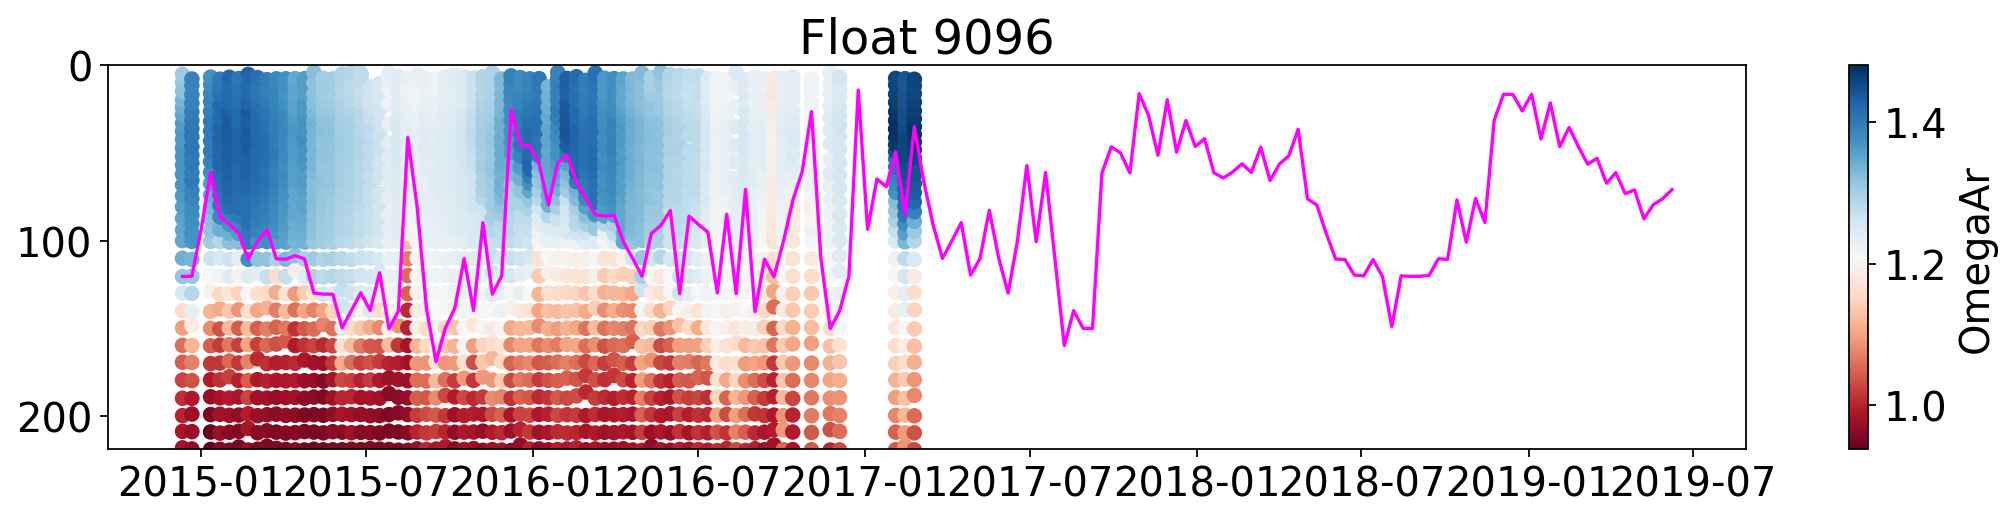

In [15]:
# Look at the saturation state of aragonite (Omega_Ar) you calculated
# First, set the depth to which you wish to plot and keep it the same for subsequent plots
depth=MLD['MLD'].max()+50 #plot to depth of mixed layer plus some number of m

var='OmegaAr'
fig = plt.figure(num=None, figsize=(16,3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'RdBu')
ax.plot(MLD['date'],MLD['MLD'],c='magenta')
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
ax.set_ylim([depth,0])
cb=plt.colorbar(sc)
cb.set_label(var)
# automatically adjusts the colorbar based on the range of values youre plotting
sc.set_clim(vmin = flt[var].loc[(flt['Depth[m]']<depth)].min(), 
            vmax = flt[var].loc[(flt['Depth[m]']<depth)].max()) 
fig.savefig(output_dir+'F'+floatnum+var[0:3]+'section.png', dpi = 200, bbox_inches='tight')

## Calculate the depth of the Aragonite Saturation Horizon
It is useful to know the depth at which aragonite transitions from being stable to unstable. In some parts of the ocean, this depth is very deep, but in the Southern Ocean it can be near the surface. 

In [16]:
# Calculate zsatarag for each station
zsatarag=[]
for station in flt['Station'].unique():
    zsatarag.append([station,flt['date'].loc[(flt['Station']==station)&(flt['OmegaAr']<1)].min(),
                flt['Depth[m]'].loc[(flt['Station']==station)&(flt['OmegaAr']<1)].min(),
              flt['Lon [°E]'].loc[(flt['Station']==station)].mean(),
              flt['Lat [°N]'].loc[(flt['Station']==station)].mean()])

# Take a look at zsatarag. First column is the Station, second column is datenum, second column is the zsatarag
zsatarag = pd.DataFrame(data=zsatarag, columns=['Station', 'date', 'zsatarag','Lon [°E]','Lat [°N]'])

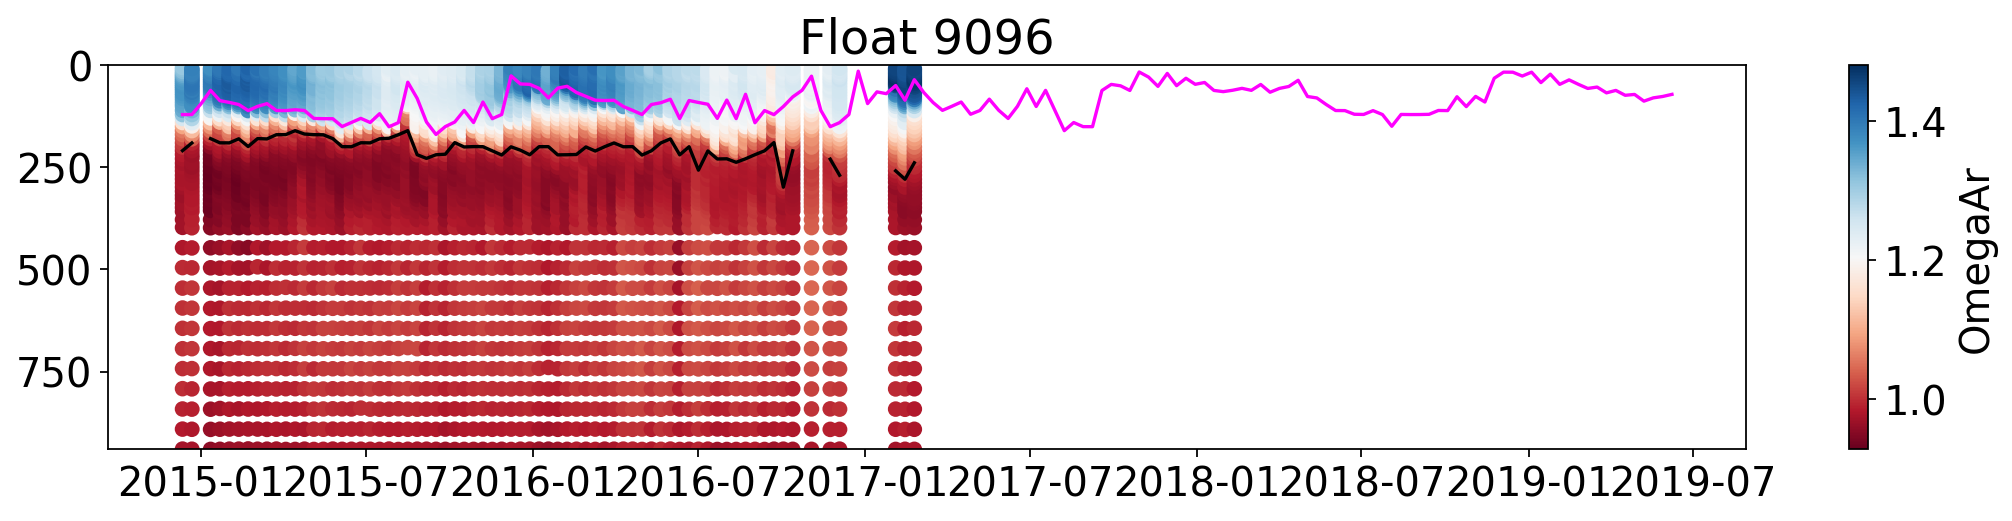

In [17]:
# Look at the zsatarag and saturation state of aragonite (Omega_Ar) you calculated
# First, set the depth to which you wish to plot and keep it the same for subsequent plots
depth=zsatarag['zsatarag'].max()+50 #plot to depth of mixed layer plus some number of m

var='OmegaAr'
fig = plt.figure(num=None, figsize=(16,3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'RdBu')
ax.plot(MLD['date'],MLD['MLD'],c='magenta')
ax.plot(zsatarag['date'],zsatarag['zsatarag'],c='black')
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
ax.set_ylim([depth,0])
cb=plt.colorbar(sc)
cb.set_label(var)
# automatically adjusts the colorbar based on the range of values youre plotting
sc.set_clim(vmin = flt[var].loc[(flt['Depth[m]']<depth)].min(), 
            vmax = flt[var].loc[(flt['Depth[m]']<depth)].max()) 
fig.savefig(output_dir+'F'+floatnum+var[0:3]+'zsataragsection.png', dpi = 200, bbox_inches='tight')

Where in the water column is the aragonite saturation horizon? What does this mean for calcifying organisms in the area? Do you think this region will be vulnerable to continued ocean acidification?

Seasonality is also important. What is the seasonality in aragonite saturation in the mixed layer? Negative impacts to organisms have been shown to occur even before aragonite saturation reaches 1.

## Make a time series plot of average top 30 m observations
Here we use the pandas groupby function to group the near-surface data by station.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [18]:
type(MLD['MLD'])

pandas.core.series.Series

In [17]:
# Need to work on this loop to use actual MLD instead of 30 m for averaging
# I also tried other options and got errors about things being mutable...
for station in MLD['Station'].unique():
    stationMLD=MLD['MLD'].loc[(MLD['Station']==station)]
    mask=flt.loc[(flt['Station']==station),(flt['Pressure[dbar]']<stationMLD)]
    fltSurf=fltSurf.append(flt[mask])

ValueError: Can only compare identically-labeled Series objects

In [27]:
fltSurf=flt.loc[(flt['Pressure[dbar]']<30)]
fltSurfByStn=fltSurf.groupby('Station').mean()

In [28]:
# Groupby doesn't work on datetime column so it was dropped. We need to make a datetime array to be used with plotting
fltdates=[]
for station in flt['Station'].unique():
    fltdates.append([flt['date'].loc[(flt['Station']==station)].min()])
len(fltdates)

160

In [29]:
# Unfortunately, sometimes the fltdates is 1 row longer than the groupby file. 
# Not sure how/why this happened but for now, we will just assume that 
# there is an extra date somewhere and drop the final date.
# Need to fix this later. It might lead to a 10-day error in the dates
if len(fltdates)>len(fltSurfByStn):
    fltdates.pop()# pop "pops off" the last value

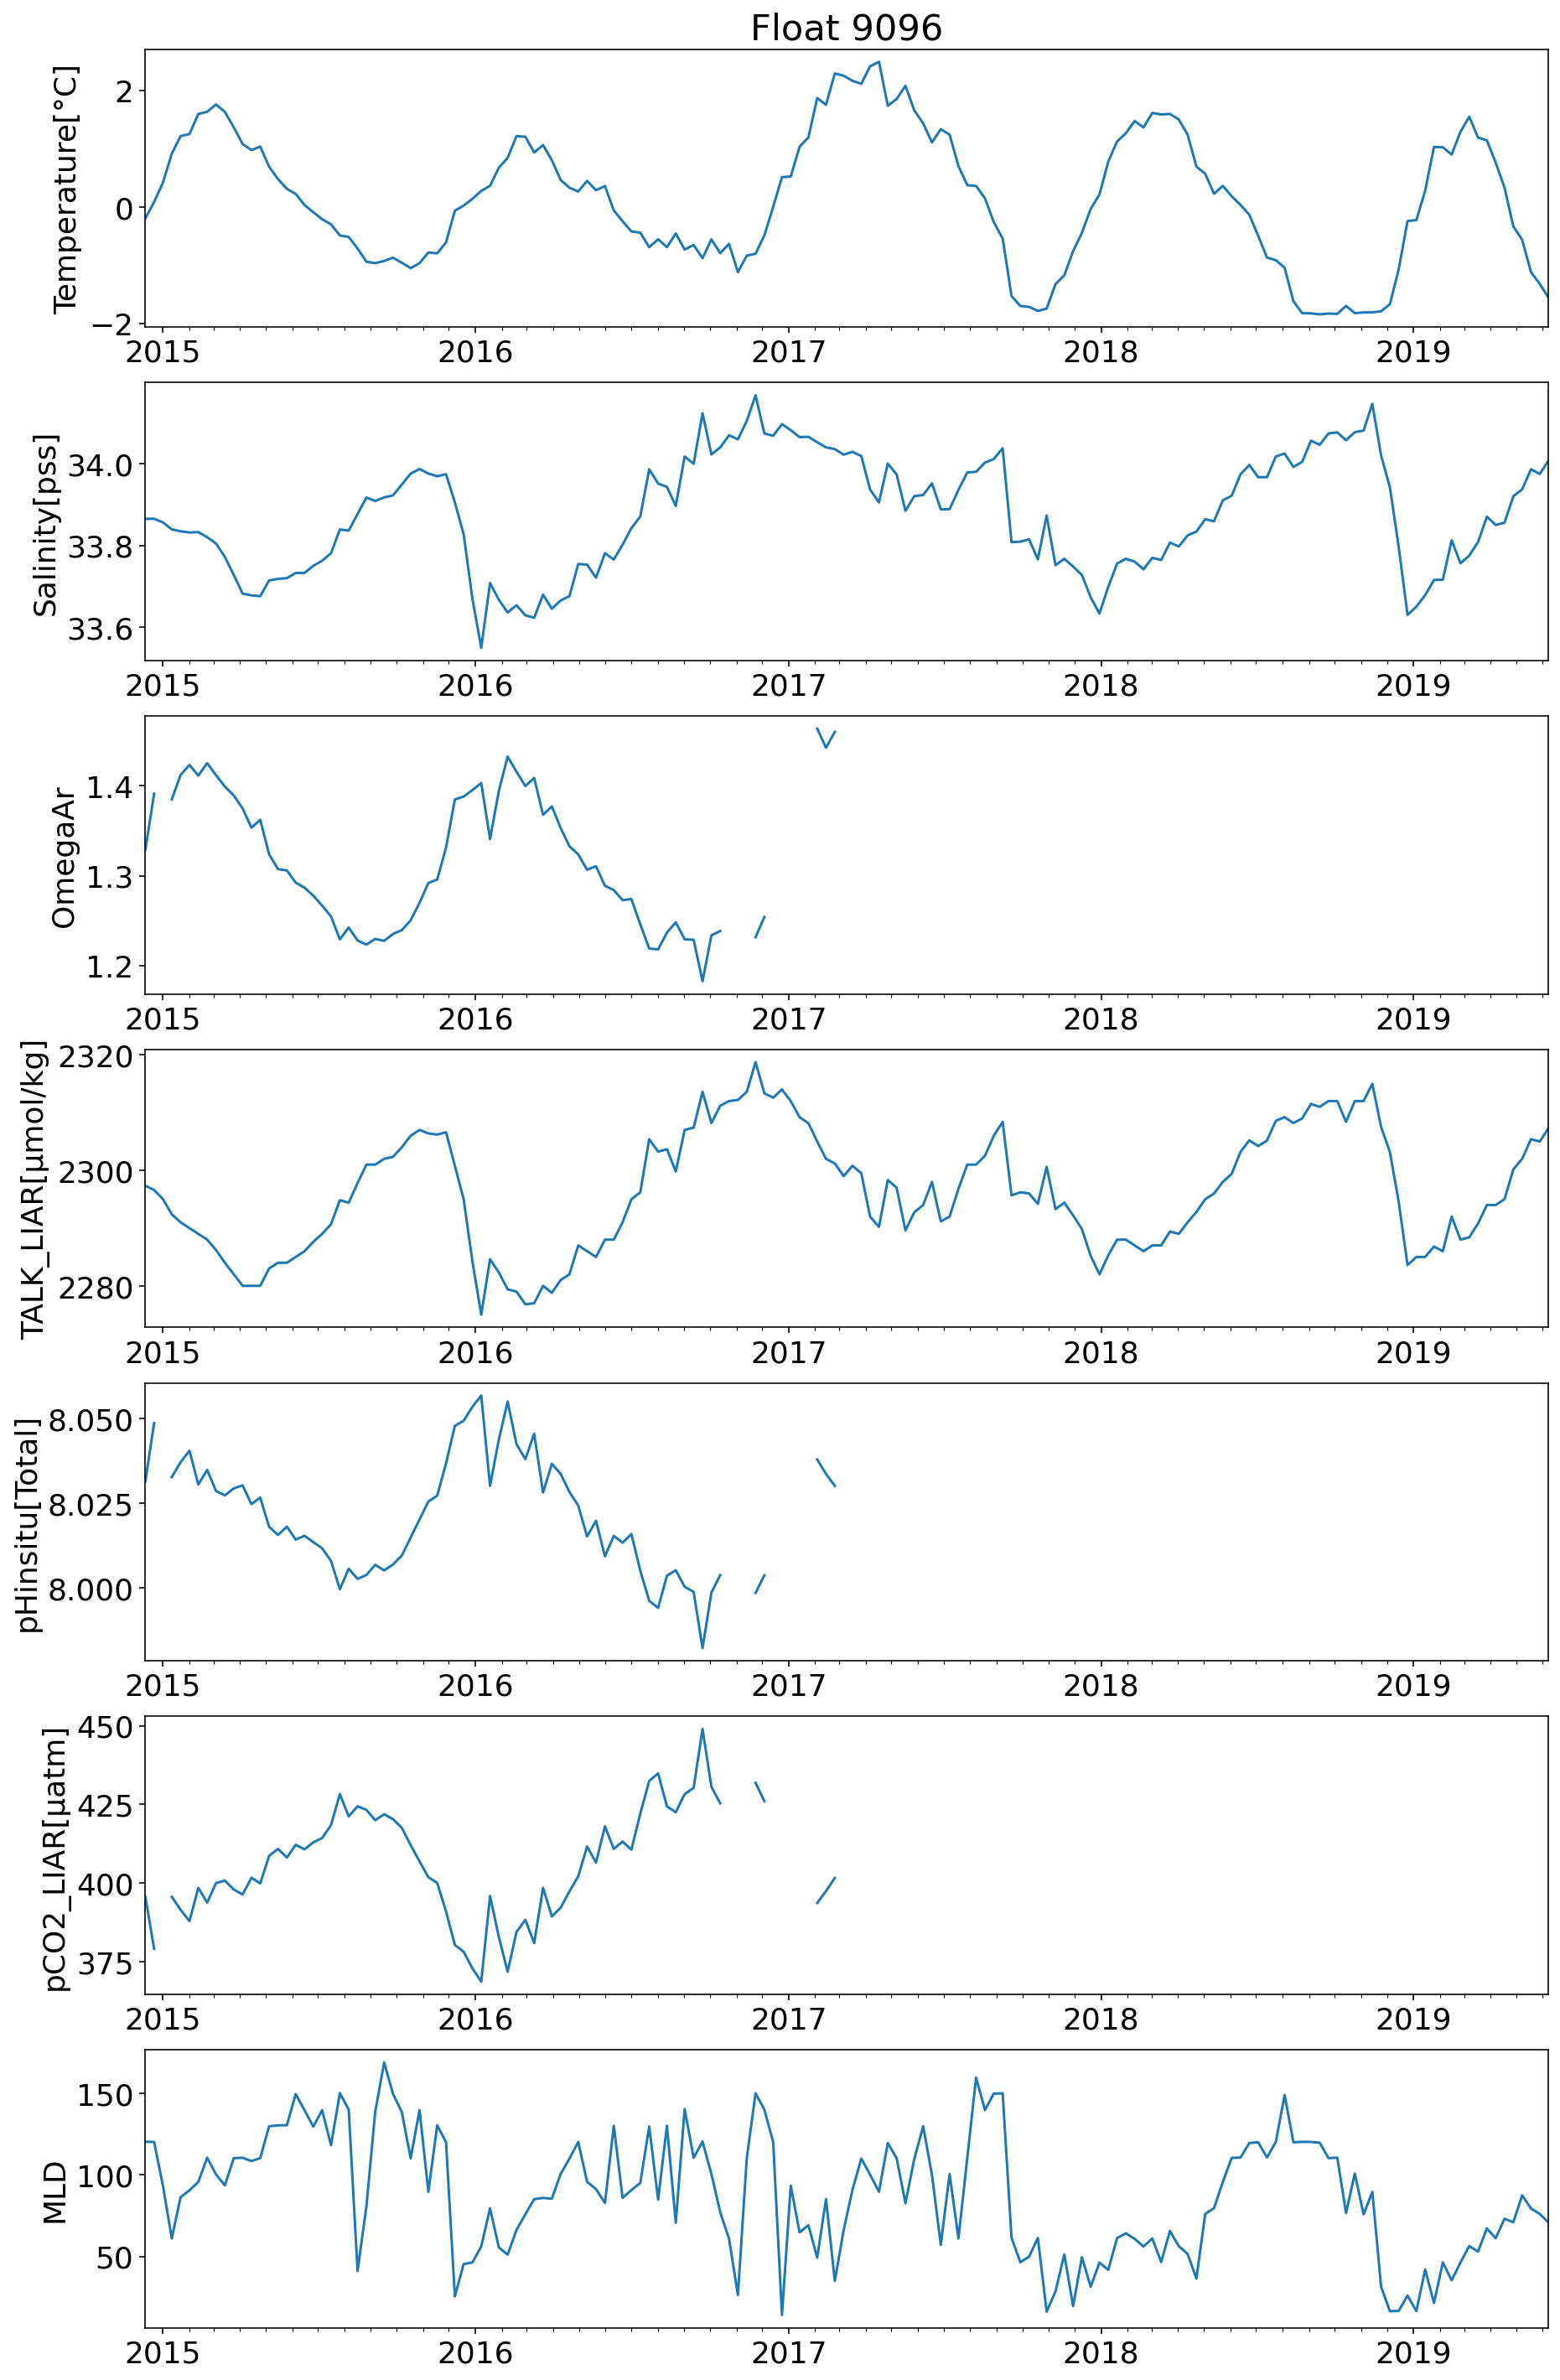

In [30]:
# Make a big plot with subplots
fig,axes = plt.subplots(nrows = 7, ncols = 1,figsize=(15,25))
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

var='Temperature[°C]'
axes[0].plot(fltdates,fltSurfByStn[var])
axes[0].set_ylabel(var)
axes[0].set_xlim(fltdates[0],fltdates[-1])
# format the ticks
axes[0].xaxis.set_major_locator(years)
axes[0].xaxis.set_major_formatter(years_fmt)
axes[0].xaxis.set_minor_locator(months)

var='Salinity[pss]'
axes[1].plot(fltdates,fltSurfByStn[var])
axes[1].set_ylabel(var)
axes[1].set_xlim(fltdates[0],fltdates[-1])
axes[1].xaxis.set_major_locator(years)
axes[1].xaxis.set_major_formatter(years_fmt)
axes[1].xaxis.set_minor_locator(months)

var='OmegaAr'
axes[2].plot(fltdates,fltSurfByStn[var])
axes[2].set_ylabel(var)
axes[2].set_xlim(fltdates[0],fltdates[-1])
axes[2].xaxis.set_major_locator(years)
axes[2].xaxis.set_major_formatter(years_fmt)
axes[2].xaxis.set_minor_locator(months)

var='TALK_LIAR[µmol/kg]'
axes[3].plot(fltdates,fltSurfByStn[var])
axes[3].set_ylabel(var)
axes[3].set_xlim(fltdates[0],fltdates[-1])
axes[3].xaxis.set_major_locator(years)
axes[3].xaxis.set_major_formatter(years_fmt)
axes[3].xaxis.set_minor_locator(months)

var='pHinsitu[Total]'
axes[4].plot(fltdates,fltSurfByStn[var])
axes[4].set_ylabel(var)
axes[4].set_xlim(fltdates[0],fltdates[-1])
axes[4].xaxis.set_major_locator(years)
axes[4].xaxis.set_major_formatter(years_fmt)
axes[4].xaxis.set_minor_locator(months)

var='pCO2_LIAR[µatm]'
axes[5].plot(fltdates,fltSurfByStn[var])
axes[5].set_ylabel(var)
axes[5].set_xlim(fltdates[0],fltdates[-1])
axes[5].xaxis.set_major_locator(years)
axes[5].xaxis.set_major_formatter(years_fmt)
axes[5].xaxis.set_minor_locator(months)

var='MLD'
axes[6].plot(MLD['date'],MLD['MLD'])
axes[6].set_ylabel(var)
axes[6].set_xlim(fltdates[0],fltdates[-1])
axes[6].xaxis.set_major_locator(years)
axes[6].xaxis.set_major_formatter(years_fmt)
axes[6].xaxis.set_minor_locator(months)

axes[0].set_title('Float '+floatnum)
# This is the first figure we're saving. We have given it a name, a type, and a dpi or
# dots per inch which is resolution
fig.savefig(output_dir+'F'+floatnum+'CO2SYS.png', dpi = 200, bbox_inches='tight')

## What will the aragonite saturation look like in 50 years?
How would you go about answering this question using CO2SYS? Some useful info is compiled in Table 5 of Williams et al. (2015):
>Williams, N. L., Feely, R. A., Sabine, C. L., Dickson, A. G., Swift, J. H., Talley, L. D., & Russell, J. L. (2015). Quantifying anthropogenic carbon inventory changes in the Pacific sector of the Southern Ocean. Marine Chemistry, 174, 147–160. https://doi.org/10.1016/j.marchem.2015.06.015

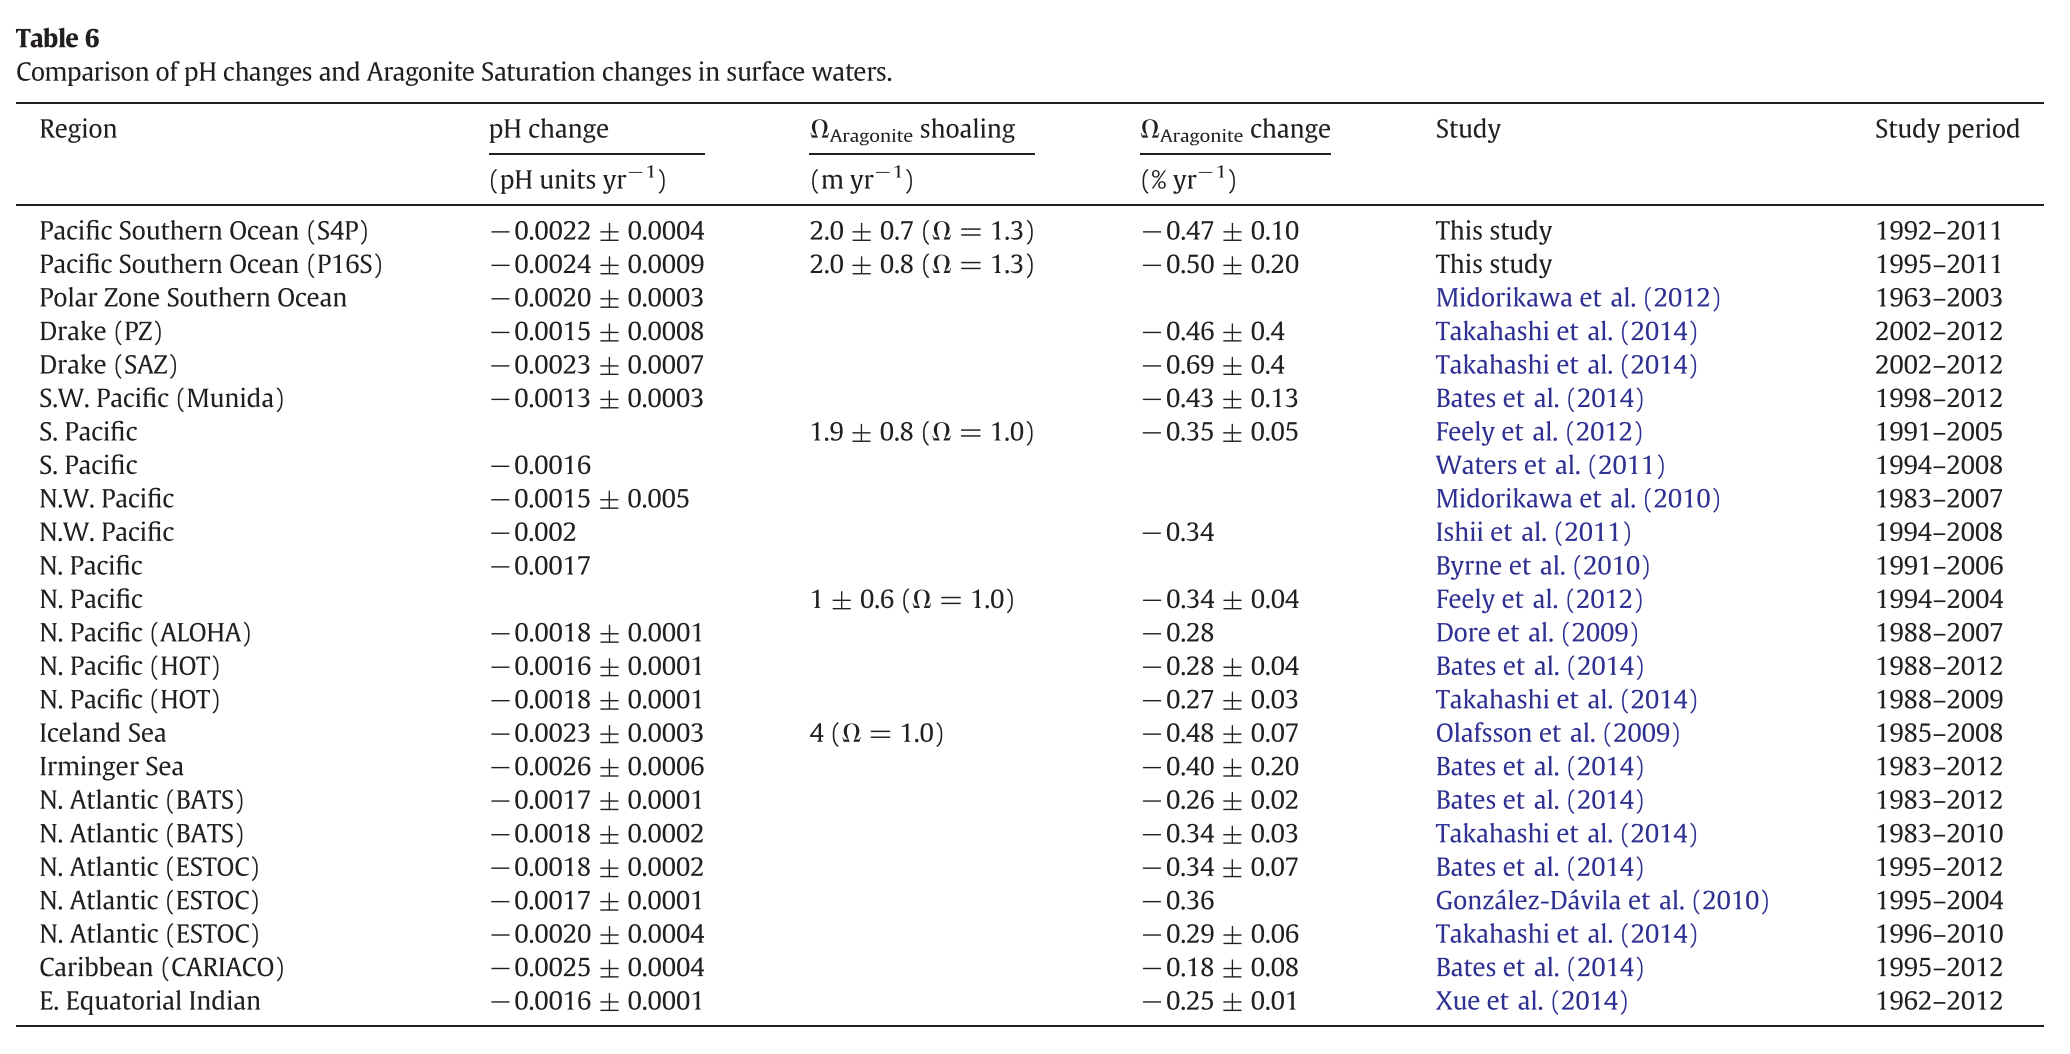

In [31]:
Image('Williamsetal2015SouthernOceanOArates.png', width=800)

The above table gives ocean acidification rates for the Southern Ocean as well as other ocean regions. The OA rate for pH for the Southern Ocean is about -0.002/year. Just for demonstration, we will subtract 50 * 0.002 from our observed surface pH in order to get the future conditions. 

As a side note: It is best to discuss and calculate OA changes in terms of [H+] and not pH because pH is a log scale and OA rates in terms of pH are therefore not linear. It is the [H+] that is changing! See technical note:
>Fassbender, A., Orr, J., & Dickson, A. (2020). Technical note: Interpreting pH changes. Biogeosciences Discussions, 10(2), 1–14. https://doi.org/10.5194/bg-2020-348

In [32]:
# Create a new variable called pH2070 to represent the pH in 50 years
fltSurfByStn['pH2070'] = fltSurfByStn['pHinsitu[Total]'] -50*(0.002)

In [33]:
# Run CO2SYS with your future pH and the same total alkalinity
df2 = co2sys(
    pH=fltSurfByStn['pH2070'], alk=fltSurfByStn['TALK_LIAR[µmol/kg]'],
    temp_in=fltSurfByStn['Temperature[°C]'], temp_out=fltSurfByStn['Temperature[°C]'], 
    pres_in=fltSurfByStn['Pressure[dbar]'], pres_out=fltSurfByStn['Pressure[dbar]'],
    sal=fltSurfByStn['Salinity[pss]'], si=0, po4=0, nh3=0, h2s=0,
    K1K2_constants=10, KSO4_constants=1, KF_constant=1, pHscale_in=1,
    buffers_mode="auto", verbose=True)
df2

# Add the newly-calculated OmegaAr2070 to the fltSurfByStn dataframe
fltSurfByStn['OmegaAr2070']=df2['OmegaARout']

Convert data to pandas.DataFrame
Removing nans for efficiency
Computing CO2 parameters
Insert nans back into DataFrame


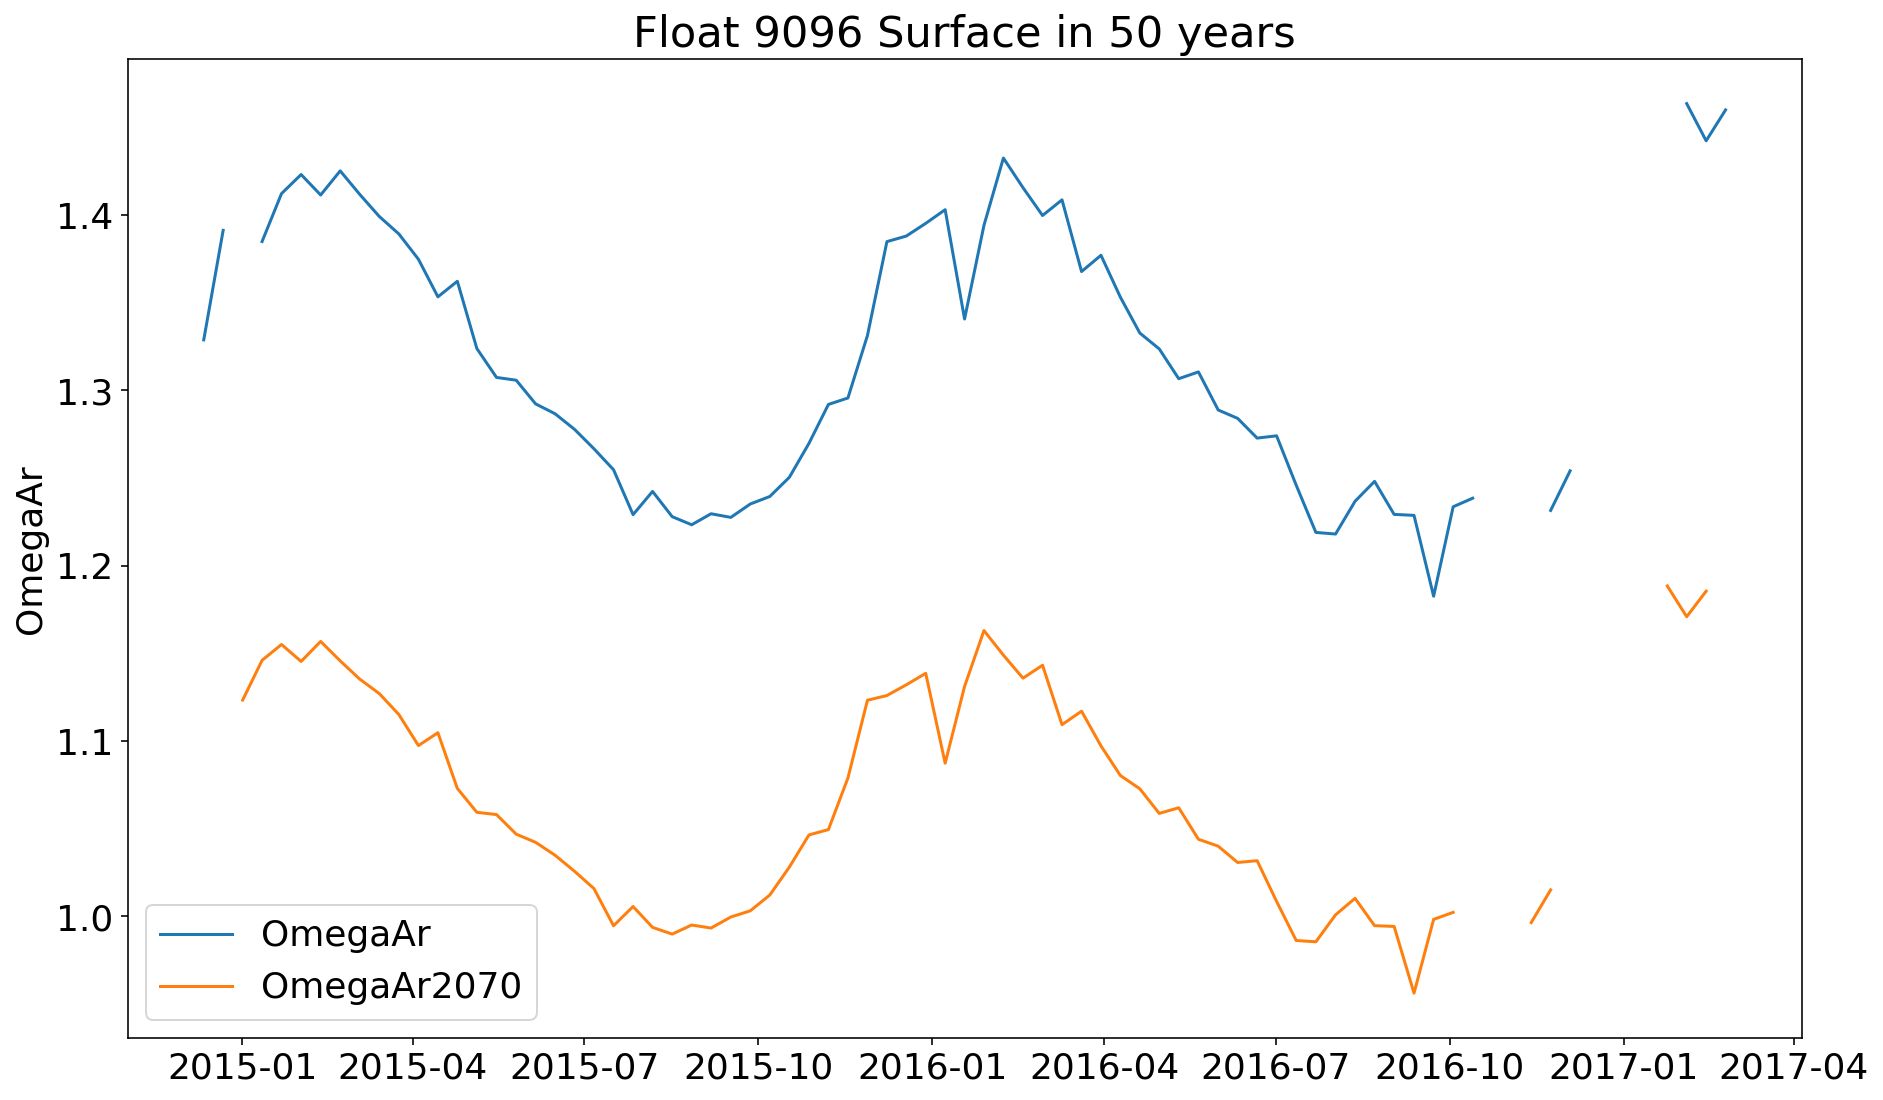

In [34]:
# plotting OmegaAr and OmegaAr2070 on one plot
fig, ax = plt.subplots()
var='OmegaAr'
var2='OmegaAr2070'
im = ax.plot(fltdates,fltSurfByStn[var],label=var)
im2 = ax.plot(fltdates,fltSurfByStn[var2],label=var2)
ax.set_ylabel(var) # fontsize=fs)
ax.legend()
plt.title('Float ' + floatnum + ' Surface in 50 years')
fig.savefig(output_dir+'F'+floatnum+'CO2SYS2070.png', dpi = 200, bbox_inches='tight')
plt.show() # displays plot